# My playing with the Kaggle titanic challenge.

I COPPIED THE INITIAL CODE and got lots of the ideas for this first Kaggle advanture from [here](https://www.kaggle.com/omarelgabry/titanic/a-journey-through-titanic/comments).

I will later compact the important stuff from here into a kernal on my Kaggle account.

In [1]:
import pandas as pd 
from pandas import Series, DataFrame
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style("whitegrid")

# machine learning
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC, LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.cross_validation import cross_val_score
from sklearn import cross_validation
from sklearn.metrics import accuracy_score
from sklearn.cross_validation import train_test_split
from sklearn.feature_selection import SelectFromModel
from sklearn.grid_search import GridSearchCV
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import SelectKBest
from sklearn.cross_validation import StratifiedKFold
from sklearn.ensemble.gradient_boosting import GradientBoostingClassifier
from sklearn.ensemble import ExtraTreesClassifier

import xgboost as xgb
from xgboost import plot_importance


In [2]:
train_df = pd.read_csv("train.csv",dtype={"Age":np.float64},)
#train_df.head()

In [3]:
# find how many ages
train_df['Age'].count()

714

In [4]:
# how many ages are NaN?
train_df['Age'].isnull().sum()

177

In [5]:
# plot ages of training data set, with NaN's removed
if False:
    train_df['Age'].dropna().astype(int).hist(bins=70)
print 'Mean age = ',train_df['Age'].dropna().astype(int).mean()

Mean age =  29.6792717087


# Let's see where they got on

In [6]:
#train_df['Embarked'].head()

In [7]:
#train_df.info()

In [8]:
train_df['Embarked'].isnull().sum()

2

In [9]:
train_df["Embarked"].count()

889

In [10]:
if False:
    sns.countplot(x="Embarked",data=train_df)

In [11]:
if False:
    sns.countplot(x='Survived',hue='Embarked',data=train_df,order=[0,1])

## OK, so clearly there were more people who got on at S, and it seems their survival is disproportional.  Let's check that.

In [12]:
if False:
    embark_survive_perc = train_df[["Embarked", "Survived"]].groupby(['Embarked'],as_index=False).mean()
    sns.barplot(x='Embarked', y='Survived', data=embark_survive_perc,order=['S','C','Q'])

## Interesting, actually those from C had higher rate of survival.  So, knowing more people from your home town didn't help.

## Next, did how much they paid have an effect?

In [13]:
if False:
    train_df['Fare'].astype(int).plot(kind='hist',bins=100, xlim=(0,50))

In [14]:
# get fare for survived & didn't survive passengers 
if False:
    fare_not_survived = train_df["Fare"].astype(int)[train_df["Survived"] == 0]
    fare_survived     = train_df["Fare"].astype(int)[train_df["Survived"] == 1]

    # get average and std for fare of survived/not survived passengers
    avgerage_fare = DataFrame([fare_not_survived.mean(), fare_survived.mean()])
    std_fare      = DataFrame([fare_not_survived.std(), fare_survived.std()])

    avgerage_fare.index.names = std_fare.index.names = ["Survived"]
    avgerage_fare.plot(yerr=std_fare,kind='bar',legend=False)

## Before digging into how the ages factor in, let's take the advice of others and replace NaN's with random values

In [15]:
import scipy.stats as stats

# column 'Age' has some NaN values
# A simple approximation of the distribution of ages is a gaussian, but this is not commonly accurate.
# lets make a vector of random ages centered on the mean, with a width of the std
lower, upper = train_df['Age'].min(), train_df['Age'].max()
mu, sigma = train_df["Age"].mean(), train_df["Age"].std()

# number of rows
n = train_df.shape[0]

print 'max: ',train_df['Age'].max()
print 'min: ',train_df['Age'].min()

# vector of random values using the truncated normal distribution.  
X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
rands = X.rvs(n)

# get the indexes of the elements in the original array that are NaN
idx = np.isfinite(train_df['Age'])

# use the indexes to replace the NON-NaNs in the random array with the good values from the original array
rands[idx.values] = train_df[idx]['Age'].values

## At this point rands is now the cleaned column of data we wanted, so push it in to the original df
train_df['Age'] = rands

"""
## we will make a new column with Nan's replaced, then push that into the original df
n = train_df.shape[0] # number of rows
#randy = np.random.randint(average_age_train - std_age_train, average_age_train + std_age_train, size = n)
# draw from a gaussian instead of simple uniform
# note this uses a 'standard gauss' and that tneeds to have its var and mean shifted
randy = np.random.randn(n)*std_age_train + average_age_train
idx = np.isfinite(train_df['Age']) # gives a boolean index for the NaNs in the df's column
randy[idx.values] = train_df[idx]['Age'].values  ## idexing the values of randy with this
#now have updated column, next push into original df
train_df['Age'] = randy
"""

print 'After this gaussian replacment, there are: ',train_df['Age'].isnull().sum()
print 'max: ',train_df['Age'].max()
print 'min: ',train_df['Age'].min()

max:  80.0
min:  0.42
After this gaussian replacment, there are:  0
max:  80.0
min:  0.42


In [16]:
# plot new Age Values
if False:
    train_df['Age'].hist(bins=70)
# Compare this to that from a few cells up for the raw ages with the NaN's dropped.  Not much different actually.

### lets perform the same NaN replacement for the 'Age' with the test data as well

In [17]:
## let's pull in the test data
test_df = pd.read_csv("test.csv",dtype={"Age":np.float64},)
#test_df.head()

In [18]:
#### Do the same for the test data
# column 'Age' has some NaN values
# A simple approximation of the distribution of ages is a gaussian, but this is not commonly accurate.
# lets make a vector of random ages centered on the mean, with a width of the std
lower, upper = test_df['Age'].min(), test_df['Age'].max()
mu, sigma = test_df["Age"].mean(), test_df["Age"].std()

# number of rows
n = test_df.shape[0]

print 'max: ',test_df['Age'].max()
print 'min: ',test_df['Age'].min()

# vector of random values using the truncated normal distribution.  
X = stats.truncnorm((lower - mu) / sigma, (upper - mu) / sigma, loc=mu, scale=sigma)
rands = X.rvs(n)

# get the indexes of the elements in the original array that are NaN
idx = np.isfinite(test_df['Age'])

# use the indexes to replace the NON-NaNs in the random array with the good values from the original array
rands[idx.values] = test_df[idx]['Age'].values

## At this point rands is now the cleaned column of data we wanted, so push it in to the original df
test_df['Age'] = rands

max:  76.0
min:  0.17


In [19]:
#test_df['Age'].hist(bins=70)

In [20]:
## Let's make a couple nice plots of survival vs age
# peaks for survived/not survived passengers by their age
if False:
    facet = sns.FacetGrid(train_df, hue="Survived",aspect=4)
    #facet.map(sns.kdeplot,'Age',shade= True) # This keeps crashing the kernal, but I don't know why!!!!!!!!!!
    facet.set(xlim=(0, train_df['Age'].astype(int).max()))
    facet.add_legend()


In [21]:
# average survived passengers by age
if False:
    fig, axis1 = plt.subplots(1,1,figsize=(18,4))
    average_age = train_df[["Age", "Survived"]].groupby(['Age'],as_index=False).mean()
    sns.barplot(x='Age', y='Survived', data=average_age)
    print 'max: ',train_df['Age'].astype(int).max()
    print 'min: ',train_df['Age'].astype(int).min()

In [22]:
# Cabin
if False:
    # It has a lot of NaN values, so it won't cause a remarkable impact on prediction
    train_df.drop("Cabin",axis=1,inplace=True)
    test_df.drop("Cabin",axis=1,inplace=True)
## OR convert NaNs to 'U' meaning 'Unknown' and map all to new columns
if True:
    # Code based on that here: http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html
    # replacing missing cabins with U (for Uknown)
    train_df.Cabin.fillna('U',inplace=True)
    # mapping each Cabin value with the cabin letter
    train_df['Cabin'] = train_df['Cabin'].map(lambda c : c[0])
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(train_df['Cabin'],prefix='Cabin')
    train_df = pd.concat([train_df,cabin_dummies],axis=1)
    train_df.drop('Cabin',axis=1,inplace=True)
    
    # replacing missing cabins with U (for Uknown)
    test_df.Cabin.fillna('U',inplace=True)
    # mapping each Cabin value with the cabin letter
    test_df['Cabin'] = test_df['Cabin'].map(lambda c : c[0])
    # dummy encoding ...
    cabin_dummies = pd.get_dummies(test_df['Cabin'],prefix='Cabin')
    test_df = pd.concat([test_df,cabin_dummies],axis=1)
    test_df.drop('Cabin',axis=1,inplace=True)
    

In [23]:
#train_df.head()
#test_df.head()

In [24]:
#train_df.head()

### This function introduces 4 new features:

- FamilySize : the total number of relatives including the passenger (him/her)self.
- Sigleton : a boolean variable that describes families of size = 1
- SmallFamily : a boolean variable that describes families of 2 <= size <= 4
- LargeFamily : a boolean variable that describes families of 5 < size

In [25]:
# Family

# Code based on that here: http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html
# introducing a new feature : the size of families (including the passenger)
train_df['FamilySize'] = train_df['Parch'] + train_df['SibSp'] + 1
# introducing other features based on the family size
train_df['Singleton'] = train_df['FamilySize'].map(lambda s : 1 if s == 1 else 0)
train_df['SmallFamily'] = train_df['FamilySize'].map(lambda s : 1 if 2<=s<=4 else 0)
train_df['LargeFamily'] = train_df['FamilySize'].map(lambda s : 1 if 5<=s else 0)

# Code based on that here: http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html
# introducing a new feature : the size of families (including the passenger)
test_df['FamilySize'] = test_df['Parch'] + test_df['SibSp'] + 1
# introducing other features based on the family size
test_df['Singleton'] = test_df['FamilySize'].map(lambda s : 1 if s == 1 else 0)
test_df['SmallFamily'] = test_df['FamilySize'].map(lambda s : 1 if 2<=s<=4 else 0)
test_df['LargeFamily'] = test_df['FamilySize'].map(lambda s : 1 if 5<=s else 0)

if False:

    # Instead of having two columns Parch & SibSp, 
    # we can have only one column represent if the passenger had any family member aboard or not,
    # Meaning, if having any family member(whether parent, brother, ...etc) will increase chances of Survival or not.
    train_df['Family'] =  train_df["Parch"] + train_df["SibSp"]
    train_df['Family'].loc[train_df['Family'] > 0] = 1
    train_df['Family'].loc[train_df['Family'] == 0] = 0

    test_df['Family'] =  test_df["Parch"] + test_df["SibSp"]
    test_df['Family'].loc[test_df['Family'] > 0] = 1
    test_df['Family'].loc[test_df['Family'] == 0] = 0

    # drop Parch & SibSp
    train_df = train_df.drop(['SibSp','Parch'], axis=1)
    test_df    = test_df.drop(['SibSp','Parch'], axis=1)

# plot
if False:
    fig, (axis1,axis2) = plt.subplots(1,2,sharex=True,figsize=(10,5))

    # sns.factorplot('Family',data=train_df,kind='count',ax=axis1)
    sns.countplot(x='Family', data=train_df, order=[1,0], ax=axis1)

    # average of survived for those who had/didn't have any family member
    family_perc = train_df[["Family", "Survived"]].groupby(['Family'],as_index=False).mean()
    sns.barplot(x='Family', y='Survived', data=family_perc, order=[1,0], ax=axis2)

    axis1.set_xticklabels(["With Family","Alone"], rotation=0)

In [26]:
# Sex

# As we see, children(age < ~16) on aboard seem to have a high chances for Survival.
# So, we can classify passengers as males, females, and child
def get_person(passenger):
    age,sex = passenger
    return 'child' if age < 16 else sex
    
train_df['Person'] = train_df[['Age','Sex']].apply(get_person,axis=1)
test_df['Person']    = test_df[['Age','Sex']].apply(get_person,axis=1)

# No need to use Sex column since we created Person column
train_df.drop(['Sex'],axis=1,inplace=True)
test_df.drop(['Sex'],axis=1,inplace=True)

# create dummy variables for Person column
person_dummies_titanic  = pd.get_dummies(train_df['Person'])
person_dummies_titanic.columns = ['Child','Female','Male']
#person_dummies_titanic.drop(['Male'], axis=1, inplace=True)

person_dummies_test  = pd.get_dummies(test_df['Person'])
person_dummies_test.columns = ['Child','Female','Male']
#person_dummies_test.drop(['Male'], axis=1, inplace=True)

train_df = train_df.join(person_dummies_titanic)
test_df    = test_df.join(person_dummies_test)
if False:
    fig, (axis1,axis2) = plt.subplots(1,2,figsize=(10,5))

    # sns.factorplot('Person',data=train_df,kind='count',ax=axis1)
    sns.countplot(x='Person', data=train_df, ax=axis1)

    # average of survived for each Person(male, female, or child)
    person_perc = train_df[["Person", "Survived"]].groupby(['Person'],as_index=False).mean()
    sns.barplot(x='Person', y='Survived', data=person_perc, ax=axis2, order=['male','female','child'])

train_df.drop(['Person'],axis=1,inplace=True)
test_df.drop(['Person'],axis=1,inplace=True)

## Not surprising, woman and children had higher survival rates.

In [27]:
# Pclass

# sns.factorplot('Pclass',data=titanic_df,kind='count',order=[1,2,3])
if False:
    sns.factorplot('Pclass','Survived',order=[1,2,3], data=train_df,size=5)

# create dummy variables for Pclass column
pclass_dummies_titanic  = pd.get_dummies(train_df['Pclass'])
pclass_dummies_titanic.columns = ['Class_1','Class_2','Class_3']
#pclass_dummies_titanic.drop(['Class_3'], axis=1, inplace=True)

pclass_dummies_test  = pd.get_dummies(test_df['Pclass'])
pclass_dummies_test.columns = ['Class_1','Class_2','Class_3']
#pclass_dummies_test.drop(['Class_3'], axis=1, inplace=True)

train_df.drop(['Pclass'],axis=1,inplace=True)
test_df.drop(['Pclass'],axis=1,inplace=True)

train_df = train_df.join(pclass_dummies_titanic)
test_df    = test_df.join(pclass_dummies_test)

In [28]:
# Ticket
# Code based on that here: http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html
# a function that extracts each prefix of the ticket, returns 'XXX' if no prefix (i.e the ticket is a digit)
def cleanTicket(ticket):
    ticket = ticket.replace('.','')
    ticket = ticket.replace('/','')
    ticket = ticket.split()
    ticket = map(lambda t : t.strip() , ticket)
    ticket = list(filter(lambda t : not t.isdigit(), ticket))
    if len(ticket) > 0:
        return ticket[0]
    else: 
        return 'XXX'
    
train_df['Ticket'] = train_df['Ticket'].map(cleanTicket)
tickets_dummies = pd.get_dummies(train_df['Ticket'],prefix='Ticket')
train_df = pd.concat([train_df, tickets_dummies],axis=1)
train_df.drop('Ticket',inplace=True,axis=1)

test_df['Ticket'] = test_df['Ticket'].map(cleanTicket)
tickets_dummies = pd.get_dummies(test_df['Ticket'],prefix='Ticket')
test_df = pd.concat([test_df, tickets_dummies],axis=1)
test_df.drop('Ticket',inplace=True,axis=1)

In [29]:
train_df.head()

,PassengerId,Survived,Name,Age,SibSp,Parch,Fare,Embarked,Cabin_A,Cabin_B,...,Ticket_SOPP,Ticket_SOTONO2,Ticket_SOTONOQ,Ticket_SP,Ticket_STONO,Ticket_STONO2,Ticket_SWPP,Ticket_WC,Ticket_WEP,Ticket_XXX
0,1,0,"Braund, Mr. Owen Harris",22.0,1,0,7.2500,S,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38.0,1,0,71.2833,C,0,0,...,0,0,0,0,0,0,0,0,0,0
2,3,1,"Heikkinen, Miss. Laina",26.0,0,0,7.9250,S,0,0,...,0,0,0,0,0,1,0,0,0,0
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35.0,1,0,53.1000,S,0,0,...,0,0,0,0,0,0,0,0,0,1
4,5,0,"Allen, Mr. William Henry",35.0,0,0,8.0500,S,0,0,...,0,0,0,0,0,0,0,0,0,1


In [30]:
# Title
# a map of more aggregated titles
Title_Dictionary = {
                    "Capt":       "Officer",
                    "Col":        "Officer",
                    "Major":      "Officer",
                    "Jonkheer":   "Royalty",
                    "Don":        "Royalty",
                    "Sir" :       "Royalty",
                    "Dr":         "Officer",
                    "Rev":        "Officer",
                    "the Countess":"Royalty",
                    "Dona":       "Royalty",
                    "Mme":        "Mrs",
                    "Mlle":       "Miss",
                    "Ms":         "Mrs",
                    "Mr" :        "Mr",
                    "Mrs" :       "Mrs",
                    "Miss" :      "Miss",
                    "Master" :    "Master",
                    "Lady" :      "Royalty"

                    }
# we extract the title from each name
train_df['Title'] = train_df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
# we map each title
train_df['Title'] = train_df.Title.map(Title_Dictionary)
#train_df.head()
# we extract the title from each name
test_df['Title'] = test_df['Name'].map(lambda name:name.split(',')[1].split('.')[0].strip())
# we map each title
test_df['Title'] = test_df.Title.map(Title_Dictionary)
#test_df.head()

In [31]:
# encoding in dummy variable
titles_dummies = pd.get_dummies(train_df['Title'],prefix='Title')
train_df = pd.concat([train_df,titles_dummies],axis=1)
titles_dummies = pd.get_dummies(test_df['Title'],prefix='Title')
test_df = pd.concat([test_df,titles_dummies],axis=1)
# removing the title variable
train_df.drop('Title',axis=1,inplace=True)
test_df.drop('Title',axis=1,inplace=True)

In [32]:
# Convert categorical column values to ordinal for model fitting
if False:
    le_title = LabelEncoder()
    # To convert to ordinal:
    train_df.Title = le_title.fit_transform(train_df.Title)
    test_df.Title = le_title.fit_transform(test_df.Title)
    # To convert back to categorical:
    #train_df.Title = le_title.inverse_transform(train_df.Title)
    #train_df.head()
    #test_df.head()

## Also unsurprising.  The higher the booking class, then higher the chances to survive.

___
___
___

# Now lets get to actually training and building a model to make predictions with!
___
___
___

## problems with the raw data
- a couple NaNs in 'Embarked', so drop column
- 'Name' strings can't be converted to anything useful, so drop column
- replace NaNs in 'Fare' with median
- 'Ticket' can't be converted to anything useful, so drop column
- 'PassengerID' has no importance, so drop column

In [33]:
#train_df.drop(['Embarked'], axis=1,inplace=True)
#test_df.drop(['Embarked'], axis=1,inplace=True)
# only for test_df, since there is a missing "Fare" values
# could use mean or median here.
test_df["Fare"].fillna(test_df["Fare"].mean(), inplace=True)
train_df.drop(['Name'], axis=1,inplace=True)
test_df.drop(['Name'], axis=1,inplace=True)

In [34]:
#train_df.drop(['Ticket'], axis=1,inplace=True)
#test_df.drop(['Ticket'], axis=1,inplace=True)

In [35]:
#train_df.drop(['PassengerId'], axis=1,inplace=True)
#test_df.drop(['PassengerId'], axis=1,inplace=True)

In [36]:
# only in titanic_df, fill the two missing values with the most occurred value, which is "S".
train_df["Embarked"] = train_df["Embarked"].fillna("S")
# Either to consider Embarked column in predictions,
# and remove "S" dummy variable, 
# and leave "C" & "Q", since they seem to have a good rate for Survival.

# OR, don't create dummy variables for Embarked column, just drop it, 
# because logically, Embarked doesn't seem to be useful in prediction.

embark_dummies_train  = pd.get_dummies(train_df['Embarked'])
#embark_dummies_train.drop(['S'], axis=1, inplace=True)

embark_dummies_test  = pd.get_dummies(test_df['Embarked'])
#embark_dummies_test.drop(['S'], axis=1, inplace=True)

train_df = train_df.join(embark_dummies_train)
test_df    = test_df.join(embark_dummies_test)

train_df.drop(['Embarked'], axis=1,inplace=True)
test_df.drop(['Embarked'], axis=1,inplace=True)

# The names are also pointless, so drop them too

In [37]:
## Scale all features except passengerID
features = list(train_df.columns)
features.remove('PassengerId')
train_df[features] = train_df[features].apply(lambda x: x/x.max(), axis=0)

features = list(test_df.columns)
features.remove('PassengerId')
test_df[features] = test_df[features].apply(lambda x: x/x.max(), axis=0)

In [38]:
train_df.head()

,PassengerId,Survived,Age,SibSp,Parch,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,...,Ticket_XXX,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,C,Q,S
0,1,0.0,0.2750,0.125,0.0,0.014151,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,1.0,0.4750,0.125,0.0,0.139136,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,1.0,0.3250,0.000,0.0,0.015469,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,1.0,0.4375,0.125,0.0,0.103644,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,5,0.0,0.4375,0.000,0.0,0.015713,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [39]:
test_df.head()

,PassengerId,Age,SibSp,Parch,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,...,Ticket_XXX,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,C,Q,S
0,892,0.453947,0.000,0.000000,0.015282,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,893,0.618421,0.125,0.000000,0.013663,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,894,0.815789,0.000,0.000000,0.018909,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,895,0.355263,0.000,0.000000,0.016908,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,896,0.289474,0.125,0.111111,0.023984,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## match up dataframe columns, by removing extras not in the test set.

In [40]:
## Remove extra columns in training DF that are not in test DF
train_cs = list(train_df.columns)
train_cs.remove('Survived')
test_cs = list(test_df.columns)
for c in train_cs:
    if c not in test_cs:
        print repr(c)+' not in test columns, so removing it from training df'
        train_df.drop([c], axis=1,inplace=True)
for c in test_cs:
    if c not in train_cs:
        print repr(c)+' not in training columns, so removing it from test df'
        test_df.drop([c], axis=1,inplace=True)

'Cabin_T' not in test columns, so removing it from training df
'Ticket_AS' not in test columns, so removing it from training df
'Ticket_CASOTON' not in test columns, so removing it from training df
'Ticket_Fa' not in test columns, so removing it from training df
'Ticket_LINE' not in test columns, so removing it from training df
'Ticket_PPP' not in test columns, so removing it from training df
'Ticket_SCOW' not in test columns, so removing it from training df
'Ticket_SOP' not in test columns, so removing it from training df
'Ticket_SP' not in test columns, so removing it from training df
'Ticket_SWPP' not in test columns, so removing it from training df
'Ticket_A' not in training columns, so removing it from test df
'Ticket_AQ3' not in training columns, so removing it from test df
'Ticket_AQ4' not in training columns, so removing it from test df
'Ticket_LP' not in training columns, so removing it from test df
'Ticket_SCA3' not in training columns, so removing it from test df
'Ticket_STO

In [41]:
if False:
    print '\nFor train_df:'
    for column in train_df:
        print "# Nans in column '"+column+"' are: "+str(train_df[column].isnull().sum())
        print 'min: ',train_df[column].min()
        print 'max: ',train_df[column].max()

    print '\nFor test_df:'
    for column in test_df:
        print "# Nans in column '"+column+"' are: "+str(test_df[column].isnull().sum())
        print 'min: ',test_df[column].min()
        print 'max: ',test_df[column].max()   

In [42]:
# define training and testing sets
X_train = train_df.drop("Survived",axis=1)
Y_train = train_df["Survived"]
X_test  = test_df.copy()

In [43]:
X_train.head()

,PassengerId,Age,SibSp,Parch,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,...,Ticket_XXX,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,C,Q,S
0,1,0.2750,0.125,0.0,0.014151,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
1,2,0.4750,0.125,0.0,0.139136,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,3,0.3250,0.000,0.0,0.015469,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,4,0.4375,0.125,0.0,0.103644,0.0,0.0,1.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
4,5,0.4375,0.000,0.0,0.015713,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0


In [44]:
X_test.head()

,PassengerId,Age,SibSp,Parch,Fare,Cabin_A,Cabin_B,Cabin_C,Cabin_D,Cabin_E,...,Ticket_XXX,Title_Master,Title_Miss,Title_Mr,Title_Mrs,Title_Officer,Title_Royalty,C,Q,S
0,892,0.453947,0.000,0.000000,0.015282,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
1,893,0.618421,0.125,0.000000,0.013663,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,894,0.815789,0.000,0.000000,0.018909,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0
3,895,0.355263,0.000,0.000000,0.016908,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
4,896,0.289474,0.125,0.111111,0.023984,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


## Feature Selection

In [45]:
clf = ExtraTreesClassifier(n_estimators=200)
clf = clf.fit(X_train, Y_train)
features = pd.DataFrame()
features['feature'] = X_train.columns
features['importance'] = clf.feature_importances_
features.sort(['importance'],ascending=False)

/home/kmede/miniconda2/envs/ExoSOFTcondaEnv/lib/python2.7/site-packages/ipykernel/__main__.py:6: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,feature,importance
0,PassengerId,0.122308
1,Age,0.120202
4,Fare,0.104768
19,Male,0.104242
47,Title_Mr,0.078914
18,Female,0.061384
22,Class_3,0.042198
46,Title_Miss,0.034166
48,Title_Mrs,0.028270
12,Cabin_U,0.027821


## Select top features for use in models

In [46]:
model = SelectFromModel(clf, prefit=True)
X_train_new = model.transform(X_train)
X_train_new.shape

X_test_new = model.transform(X_test)
X_test_new.shape

(418, 14)

In [47]:
# Logistic Regression
logreg = LogisticRegression()

logreg.fit(X_train_new, Y_train)

Y_pred = logreg.predict(X_test_new)

print('standard score ', logreg.score(X_train_new, Y_train))
print('cv score ',np.mean(cross_val_score(logreg, X_train_new, Y_train, cv=10)))


('standard score ', 0.83164983164983164)
('cv score ', 0.82940926115083413)


In [48]:
# Support Vector Machines
svc = SVC()

svc.fit(X_train_new, Y_train)

Y_pred = svc.predict(X_test_new)

#svc.score(X_train, Y_train)
print('standard score ', svc.score(X_train_new, Y_train))
print('cv score ',np.mean(cross_val_score(svc, X_train_new, Y_train, cv=10)))


('standard score ', 0.83726150392817056)
('cv score ', 0.52969072749971624)


In [53]:
# Random Forests
random_forest = RandomForestClassifier(n_estimators=300)
random_forest.fit(X_train_new, Y_train)
Y_pred = random_forest.predict(X_test_new)
print('standard score ', random_forest.score(X_train_new, Y_train))
print('cv score ',np.mean(cross_val_score(random_forest, X_train_new, Y_train, cv=10)))



('standard score ', 1.0)
('cv score ', 0.81927136533878109)


('maxes were: ', (270, 82.27588112151733))


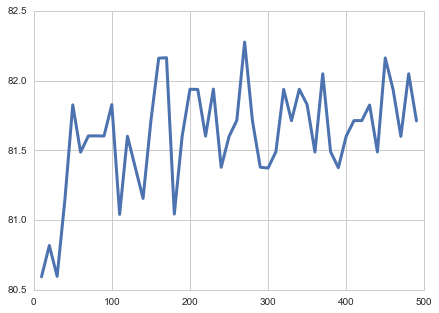

In [55]:
acc = []
mx_v = 0
mx_e = 0
ests = range(10,500,10)
if False:
    for est in ests:
        random_forest = RandomForestClassifier(n_estimators=est)
        random_forest.fit(X_train_new, Y_train)
        Y_pred = random_forest.predict(X_test_new)
        #predictions = model.predict(X_test)
        #accuracy = accuracy_score(y_test, predictions)
        accuracy = np.mean(cross_val_score(random_forest, X_train_new, Y_train, cv=5))* 100.0
        acc.append(accuracy)
        if acc[-1]>mx_v:
            mx_v = acc[-1]
            mx_e = est
    print("maxes were: ",(mx_e,mx_v))
        
    fig = plt.figure(figsize=(7,5))     
    subPlot = fig.add_subplot(111)
    subPlot.plot(ests,acc,linewidth=3)

In [50]:
# From Comment by 'Ewald' at:
# https://www.kaggle.com/c/job-salary-prediction/forums/t/4000/how-to-add-crossvalidation-to-scikit-randomforestregressor
if True:
    num_folds = 10
    num_instances = len(X_train_new)
    seed = 7
    num_trees = 300
    max_features = 'auto'
    kfold = cross_validation.KFold(n=num_instances, n_folds=num_folds, random_state=seed)
    model = RandomForestClassifier(n_estimators=num_trees, max_features=max_features,
    min_samples_leaf=50)
    results= cross_validation.cross_val_score(model, X_train_new, Y_train, cv=kfold, n_jobs=-1)
    print(results.mean())

0.801335830212


In [65]:
# Another form of K-fold and hyperparameter tuning from:
#http://ahmedbesbes.com/how-to-score-08134-in-titanic-kaggle-challenge.html
forest = RandomForestClassifier(max_features='sqrt')

parameter_grid = {
                 'max_depth' : [3,4,5,6,7],
                 'n_estimators': [50,100,130,175,200,210,240,250],
                 'criterion': ['gini','entropy']
                 }

cross_validation = StratifiedKFold(Y_train, n_folds=5)
import timeit
tic=timeit.default_timer()
grid_search = GridSearchCV(forest,
                           param_grid=parameter_grid,
                           cv=cross_validation)

grid_search.fit(X_train_new, Y_train)

print('Best score: {}'.format(grid_search.best_score_))
print('Best parameters: {}'.format(grid_search.best_params_))
toc = timeit.default_timer()
print("It took: ",toc-tic)

Best score: 0.829405162738
Best parameters: {'n_estimators': 250, 'criterion': 'gini', 'max_depth': 3}
('It took: ', 188.01947593688965)


In [62]:
# K Nearest Neighbors 
knn = KNeighborsClassifier(n_neighbors = 50)

knn.fit(X_train_new, Y_train)

Y_pred = knn.predict(X_test_new)

#knn.score(X_train_new, Y_train)

print('standard score ', knn.score(X_train_new, Y_train))
print('cv score ',np.mean(cross_val_score(knn, X_train_new, Y_train, cv=10)))


('standard score ', 0.62177328843995505)
('cv score ', 0.59032743161956647)


In [51]:
# Gaussian Naive Bayes
gaussian = GaussianNB()

gaussian.fit(X_train_new, Y_train)

Y_pred = gaussian.predict(X_test_new)

#gaussian.score(X_train, Y_train)
print('standard score ', gaussian.score(X_train_new, Y_train))
print('cv score ',np.mean(cross_val_score(gaussian, X_train_new, Y_train, cv=10)))


('standard score ', 0.81481481481481477)
('cv score ', 0.8137660310974919)


In [54]:
# get Correlation Coefficient for each feature using Logistic Regression
coeff_df = DataFrame(train_df.columns.delete(0))
coeff_df.columns = ['Features']
coeff_df["Coefficient Estimate"] = pd.Series(logreg.coef_[0])

# preview
#coeff_df

<font color='red'> NEXT: TRY TO PERFORM BOOSTING WITH SKLEARN, NOT XGBoost to see how it changes above results.  THEN TRY TO BUILD SINGLE LAYER NEURAL NETWORKS TO SEE HOW THEY PERFORM, THEN TRY MULTI-LAYER NEURAL NETWORKS.</font>

___
___
___
# XGBoost stuff 

___
___
___

In [41]:
if False:
    submission = pd.DataFrame({
            "PassengerId": test_df["PassengerId"],
            "Survived": Y_pred
        })
    submission.to_csv('submission.csv', index=False)

In [42]:
if False:
    ### Using XGboost
    #X_train = train_df.drop("Survived",axis=1)
    #train_X = train_df.drop("Survived",axis=1).as_matrix()
    X_train_new
    #X_train_new, Y_train, X_test_new
    #train_y = train_df["Survived"]
    Y_train
    #test_X = test_df.drop("PassengerId",axis=1).copy().as_matrix()
    X_test_new
    model = xgb.XGBClassifier(max_depth=10, n_estimators=300, learning_rate=0.05)
    model.fit(X_train_new, Y_train)
    predictions = model.predict(X_test_new)
    # plot feature importance
    plot_importance(model)
    plt.show()
    #X_train, X_test, y_train, y_test = train_test_split(X_train_new, Y_train, test_size=0.33)
    #accuracy = accuracy_score(y_test, predictions)
    #print("Accuracy: %.2f%%" % (accuracy * 100.0))


In [43]:
# basic try at iterative training with XGboost
#train_X = train_df.drop("Survived",axis=1).as_matrix()
#train_y = train_df["Survived"]
#test_X = test_df.drop("PassengerId",axis=1).copy().as_matrix()
# fit model on all training data
acc = []
mx_v = 0
mx_e = 0
ests = range(10,500,10)
if False:
    for est in ests:
        #print est
        model = xgb.XGBClassifier(max_depth=5, n_estimators=ests, learning_rate=0.05)
        X_train, X_test, y_train, y_test = train_test_split(X_train_new, Y_train, test_size=0.33)#, random_state=7)
        model.fit(X_train, y_train)
        predictions = model.predict(X_test)
        accuracy = accuracy_score(y_test, predictions)
        accuracy *= 100.0
        acc.append(accuracy)
        #print("Accuracy: %.2f%%" % (accuracy))
        if acc[-1]>mx_v:
            mx_v = acc[-1]
            mx_e = est
    print("maxes were: ",(mx_e,mx_v))

    fig = plt.figure(figsize=(7,5))     
    subPlot = fig.add_subplot(111)
    subPlot.plot(ests,acc,linewidth=3)


model = xgb.XGBClassifier(max_depth=5, n_estimators=300, learning_rate=0.05)
for i in range(10):
    print "Iteration: "+str(i)
    # split data into train and test sets
    X_train, X_test, y_train, y_test = train_test_split(X_train_new, Y_train, test_size=0.33)#, random_state=7)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    accuracy = accuracy_score(y_test, predictions)
    print("Accuracy: %.2f%%" % (accuracy * 100.0))

print "After rounds of training.  Results on original training data:"
predictions = model.predict(train_X)
accuracy = accuracy_score(train_y, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))


Iteration: 0
Accuracy: 80.34%
Iteration: 1
Accuracy: 73.90%
Iteration: 2
Accuracy: 77.63%
Iteration: 3
Accuracy: 80.00%
Iteration: 4
Accuracy: 81.36%
Iteration: 5
Accuracy: 78.64%
Iteration: 6
Accuracy: 80.00%
Iteration: 7
Accuracy: 77.63%
Iteration: 8
Accuracy: 80.68%
Iteration: 9
Accuracy: 81.36%


In [41]:
# use feature importance for feature selection
from numpy import loadtxt
from numpy import sort
from xgboost import XGBClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import SelectFromModel
import timeit
tic=timeit.default_timer()
# load data
#dataset = loadtxt('pima-indians-diabetes.csv', delimiter=",")
# split data into X and y
X = X_train_new
Y = Y_train
# split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=7)
# fit model on all training data
model = XGBClassifier(max_depth=10, nthread=100, n_estimators=300, learning_rate=0.05)
model.fit(X_train, y_train)
# make predictions for test data and evaluate
y_pred = model.predict(X_test)
predictions = [round(value) for value in y_pred]
accuracy = accuracy_score(y_test, predictions)
print("Accuracy: %.2f%%" % (accuracy * 100.0))
toc = timeit.default_timer()
print("It took: ",toc-tic)

# Fit model using each importance as a threshold
if False:
    thresholds = sort(model.feature_importances_)
    for thresh in thresholds:
        # select features using threshold
        selection = SelectFromModel(model, threshold=thresh, prefit=True)
        select_X_train = selection.transform(X_train)
        # train model
        selection_model = XGBClassifier(max_depth=10, nthread=100, n_estimators=300, learning_rate=0.05)
        selection_model.fit(select_X_train, y_train)
        # eval model
        select_X_test = selection.transform(X_test)
        y_pred = selection_model.predict(select_X_test)
        predictions = [round(value) for value in y_pred]
        accuracy = accuracy_score(y_test, predictions)
        print("Thresh=%.3f, n=%d, Accuracy: %.2f%%" % (thresh, select_X_train.shape[1], accuracy*100.0))

Accuracy: 76.61%
('It took: ', 5.418628931045532)


In [42]:
cv_params = {'max_depth': [3], 'min_child_weight': [1]}
ind_params = {'learning_rate': 0.05, 'n_estimators': 100, 'nthread':100, 'seed':0, 'subsample': 0.8, 'colsample_bytree': 0.8, 
             'objective': 'binary:logistic'}
optimized_GBM = GridSearchCV(xgb.XGBClassifier(**ind_params), cv_params, 
                             scoring = 'accuracy', cv = 2, n_jobs = -1) 

import timeit
tic=timeit.default_timer()
#X_train_new, Y_train, X_test_new

#optimized_GBM.fit(X_train_new, Y_train)

#optimized_GBM.grid_scores_
toc = timeit.default_timer()
print("It took: ",toc-tic)

('It took: ', 0.002824068069458008)
